In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import savReaderWriter

# Income in America

I want to determine what the most important factors are in detemrining an individuals income in America. 

Specifically, I want to know if years of education or race are more influentail in determining income.

To do this, I will using data from the General Social Survey (GSS) which contains a multitude of information gathered from people living in the United States gathered around every 2 years since 1972 and put it in a linear regression model. 

I will use a standard significance level of 0.05 for this excersize.

I will begin by importing my data

In [2]:
# function to the GSS sav files and return them as dataframes
def import_sav(filepath):
    with savReaderWriter.SavReader(filepath) as reader:
        header = reader.header
        records = reader.all()
        header_str = []
        for feature in header:
            header_str.append(feature.decode('ascii'))
        df = pd.DataFrame(records, columns = header_str)
        return df

In [3]:
# import the sav files
work00 = import_sav('C:\\Code\\SSP\\work00.sav')
work02 = import_sav('C:\\Code\\SSP\\work02.sav')
work04 = import_sav('C:\\Code\\SSP\\work04.sav')
work06 = import_sav('C:\\Code\\SSP\\work06.sav')
work08 = import_sav('C:\\Code\\SSP\\work08.sav')
work10 = import_sav('C:\\Code\\SSP\\work10.sav')
work12 = import_sav('C:\\Code\\SSP\\work12.sav')
work14 = import_sav('C:\\Code\\SSP\\work14.sav')
work16 = import_sav('C:\\Code\\SSP\\work16.sav')

Now that I have the the different GSS years, I need to combine them into one dataframe.

In [4]:
# create a list of common features between all GSS years
shared_features = list(set(work16.columns).intersection(work14.columns))
shared_features = list(set(shared_features).intersection(work12.columns))
shared_features = list(set(shared_features).intersection(work10.columns))
shared_features = list(set(shared_features).intersection(work08.columns))
shared_features = list(set(shared_features).intersection(work06.columns))
shared_features = list(set(shared_features).intersection(work04.columns))
shared_features = list(set(shared_features).intersection(work02.columns))
shared_features = list(set(shared_features).intersection(work00.columns))

In [5]:
len(shared_features)

407

In [6]:
work_mult = pd.concat([work16[shared_features],work14[shared_features],work12[shared_features],
                       work10[shared_features],work08[shared_features],work06[shared_features],work04[shared_features],
                       work02[shared_features],work00[shared_features]])

In [7]:
work_mult.reset_index(drop=True,inplace=True)

In [8]:
work_mult.shape

(24350, 407)

In [9]:
work_mult.head()

,POLABUSE,HELPSICK,RELHH1,TEENS,COLRAC,PARBORN,NATAID,RESPNUM,WHOELSE3,RELIG,...,POSTLIFE,CONFINAN,CONCLERG,FAIR,UNRELAT,GENDER3,RELHH5,WKSUBS,PRESTG10,WHOELSE2
0,0.0,0.0,1.0,2.0,4.0,0.0,3.0,1.0,2.0,4.0,...,2.0,0.0,0.0,0.0,0.0,1.0,4.0,3.0,60.0,2.0
1,2.0,1.0,1.0,0.0,0.0,0.0,8.0,1.0,2.0,4.0,...,1.0,1.0,3.0,1.0,-1.0,0.0,0.0,3.0,40.0,2.0
2,2.0,3.0,1.0,0.0,5.0,0.0,3.0,1.0,1.0,2.0,...,1.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,38.0,2.0
3,0.0,0.0,1.0,2.0,4.0,0.0,3.0,2.0,2.0,2.0,...,1.0,0.0,0.0,0.0,0.0,1.0,41.0,3.0,35.0,2.0
4,2.0,1.0,1.0,0.0,4.0,0.0,0.0,2.0,2.0,4.0,...,2.0,3.0,3.0,2.0,0.0,2.0,0.0,3.0,31.0,1.0


# Cleaning Data

I have all the survey years, now I must prepare the data for modeling.

I will drop all the columns with null values, and clean my variables of interest. Since my data is survey data, their are many entries which refer to no applicable answers, no response, or other things of that nature. 

In [10]:
null_col = work_mult.columns[work_mult.isna().any()].tolist()
work_mult = work_mult.drop(null_col,1)
print('dropped columns {} with nulls'.format(null_col))

dropped columns ['ISCO88', 'MAISCO88', 'SPISCO88', 'PAISCO88'] with nulls


In [11]:
# drop people for whom income was non-applicable
work_mult = work_mult.drop(work_mult[work_mult['CONINC']==0].index)

In [12]:
work_mult['YEAR'] = work_mult['YEAR'].astype(int)

In [13]:
# clean education level variable
new_edu = []
for num in work_mult['EDUC']:
    num = int(num)
    # drop 'don't know' and 'no response'
    if num == 98 or num == 99:
        new_edu.append(0)
    # drop education levels where the respondant did not complete elementary school
    elif num in range(1,5):
        new_edu.append(0)
    else:
        new_edu.append(num)
        
work_mult['EDUC'] = new_edu 

In [14]:
work_mult = work_mult.drop(work_mult[work_mult['EDUC']==0].index)

In [15]:
# create a new race variable with str categories
new_race = []
for num in work_mult['RACE']:
    num = int(num)
    if num == 1:
        new_race.append('White')
    elif num == 2:
        new_race.append('Black')
    elif num == 3:
        new_race.append('Other')
        
work_mult['Race'] = new_race 

In [16]:
new_age = []
for age in work_mult['AGE']:
    age = int(age)
    # only keep age value 89 or less, oldest respondants are 89
    if age < 90:
        new_age.append(age)
    else:
        new_age.append(0)
        
work_mult['AGE'] = new_age

In [17]:
work_mult = work_mult.drop(work_mult[work_mult['AGE']==0].index)

In [18]:
work_mult.reset_index(inplace=True)

In [19]:
work_mult['Income'] = work_mult['CONINC']

# Visualizing Data

First, I want to make sure my data has no outliers

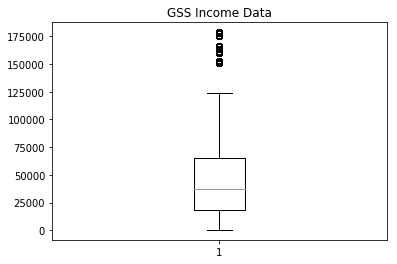

In [20]:
plt.boxplot(work_mult['Income'])
plt.title('GSS Income Data')
plt.show()

There, appear to be a few. I need to remove them. 

In [21]:
work_mult['Income'].describe()

count     21269.000000
mean      49461.009169
std       42859.170452
min         363.000000
25%       18241.000000
50%       37372.500000
75%       65668.000000
max      178712.464940
Name: Income, dtype: float64

In [22]:
# user IQR*1.5 + Q3 for upper outlier bound
outlier = (59542-17242.5) * 1.5 + 59542

In [23]:
new_inc = []
for inc in work_mult['Income']:
    if inc < outlier:
        new_inc.append(inc)
    else:
        new_inc.append(-1)
        
work_mult['Income'] = new_inc

In [24]:
work_mult = work_mult.drop(work_mult[work_mult['Income']==-1].index)

In [25]:
work_mult.reset_index(drop=True,inplace=True)

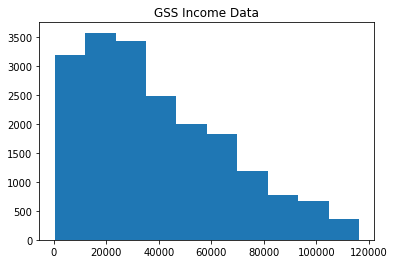

In [26]:
plt.hist(work_mult['Income'])
plt.title('GSS Income Data')
plt.show()

My outcome variable is not normally distributed, I will keep that in mind while modeling. Though it is not required for my outcome to be normal, it is required that the residuals of my model have a normal distribution.

Another important part of regressive modeling is making sure there is a linear or somewhat linear relationship between the outcome and the features.

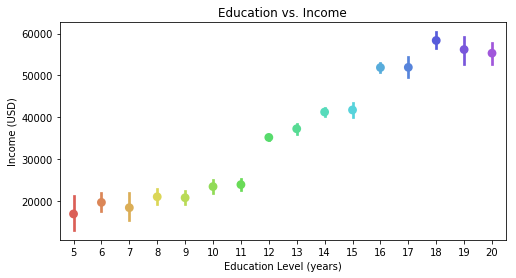

In [27]:
fig, ax = plt.subplots(figsize=(8,4))
sns.axes_style("white")
sns.pointplot(x="EDUC",
              y="Income",
              data=work_mult,
              alpha=0.1,
              palette=sns.color_palette("hls", 20),
              ax=ax)
plt.title('Education vs. Income')
plt.xlabel('Education Level (years)')
plt.ylabel('Income (USD)')
plt.show()

Here I will note that the values in education relate to how many years of school someone has attended. The value starts at 5, meaning the lowest represented Education value is individuals with 5 years (or less) of formal schooling. 

Years of Education certainly has a near linear relationship between itself and Income, so I can use modeling to determine how it and Income interact.

How does Race relate to Income?

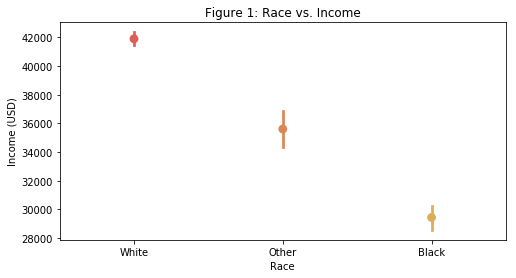

In [28]:
fig, ax = plt.subplots(figsize=(8,4))
sns.axes_style("white")
plt.tick_params(zorder=2.0)
sns.pointplot(x="Race"
            ,y="Income"
            ,data=work_mult
            ,alpha=0.1
             ,palette=sns.color_palette("hls", 20)
             ,ax=ax)
plt.title('Figure 1: Race vs. Income')
plt.ylabel('Income (USD)')
plt.show()

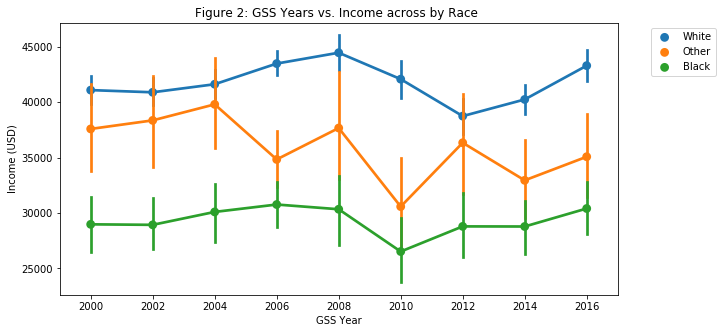

In [29]:
# Looking for overall patterns
fig, ax = plt.subplots(figsize=(10,5))
sns.axes_style("white")
sns.pointplot(x="YEAR"
            ,y="Income"
            ,hue='Race'
            ,data=work_mult
             ,ax=ax)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.title('Figure 2: GSS Years vs. Income across by Race ')
plt.xlabel('GSS Year')
plt.ylabel('Income (USD)')
plt.show()

It is important here to note that I am only using the race categories of white, black, or other. This is purely out of neccessity, as my computers and most others would not be able to handle the model I intend to use with more groups.

Since Race it categorical, it can be more difficult to see if it relates linearly to Income. Forntunately, between the 2 visualizations it is very clear that race has a somewhat linear impact on Income, certainly enough for a categorical variable. So I can use modeling to see how it relates to income.

Age is another factor that can affect Income, but probably not in linear ways. How do Age and Income relate?

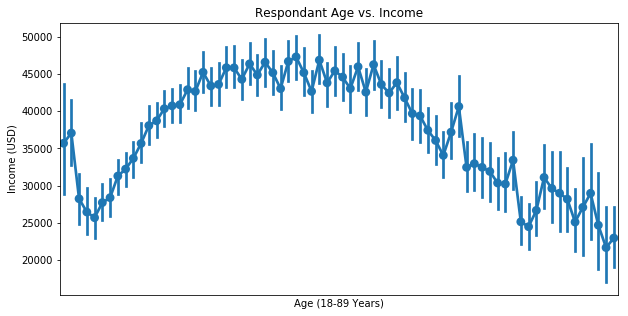

In [30]:
# Looking for overall patterns
fig, ax = plt.subplots(figsize=(10,5))
# possibly put some years on axis
plt.xticks(np.arange(18, 90, 4))
plt.tick_params(axis='x',
                which='both',
                bottom=False,
                top=False,
                labelbottom=False)
sns.axes_style("white")
sns.pointplot(x="AGE",
              y="Income",
              data=work_mult,
              ax=ax)
plt.title('Respondant Age vs. Income')
plt.xlabel('Age (18-89 Years)')
plt.ylabel('Income (USD)')
plt.show()

Age certainly affects Income, but I would not be able to evalute how through linear regression alone since it does not relate to it in any linear way. 

More troubling, the income data coming from 18-25 year olds is very similar to the Income data coming from 70-89 years olds. This makes sense, because younger people usually have less experiance, thus get lower paying jobs with less income and older people have retired thus have lower income as well. However, these groups are socially very different, the way that race and education affect income for younger people is not neccesarily the same as the way that race and education affected the people of the past.  In fact, a person's age may change how their race and education affect their income.

I don't want these possible differences to affect my results, so I will model with a Mixed Effect Linear Regression model, where my groups will be based on respondant age. This way, each age group can be allowed to interact with the parameters differently.

# Calculate ICC

Before I can use a Mixed Effect, or ME, model, I must make sure that the classes, or age grouos, have dependency. This means that results between members of the same group are more similar to each other than members of the entire dataset. 

This is done be calculating the IntraClass Correlation (ICC).

In [31]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.mixed_linear_model import MixedLMParams

In [32]:
# Model to use for calculating the ICC
print('running...')
model = smf.mixedlm("Income ~ 1",data=work_mult,groups=work_mult['AGE'])
result = model.fit(method='nm',maxiter=200, full_output=True)
print(result.summary())
print("done!")

# Function to calculate the intraclass correlation
def ICC(fittedmodel):
    between_var= fittedmodel.cov_re.iloc[0,0]
    resid=fittedmodel.scale
    icc=between_var/(between_var+resid)
    return icc

print('The Intraclass Correlation is: {}'.format(ICC(result)))

running...
             Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  Income        
No. Observations:   19526    Method:              REML          
No. Groups:         72       Scale:               709940191.5010
Min. group size:    39       Likelihood:          -226779.1163  
Max. group size:    436      Converged:           Yes           
Mean group size:    271.2                                       
----------------------------------------------------------------
             Coef.     Std.Err.   z    P>|z|   [0.025    0.975] 
----------------------------------------------------------------
Intercept    37283.662  874.833 42.618 0.000 35569.021 38998.304
Group Var 51351096.549  352.494                                 

done!
The Intraclass Correlation is: 0.06745262602493149


So, people of the same age are more than 7% more similar than people of any age. This is greater than the overall significance I set and thus I can used ME models with this data and situation.

# Modeling with Mixed Effects

Mixed Effect models are made up of both 'fixed' and 'random' effects. Fixed effects are the trends that the entire data set follows and every parameter will have fixed effects (the intercept may be fixed of random). Random effect are the trends that only effect members of the same group, in this case people of the same age; not every parameter will have random effects, and finding which parameter should have random effects and which should not is one of the most important parts of ME modelings.

## Running Different RE Configurations

Though the model I am using may be mixed effect, it is still linear regression and such will try and optimize a basic linear formula. Here, this formula looks something like this:

$$Income_{age} = intercept + X*education + Y*race$$

I need to decide if I will have a fixed or random intercept, a fixed or random education coefficient/slope, and finally a fixed or random race coefficient/slope.

This leads to 7 different configurations in total: 
1. Random Intercept, Random Education Slope AND Random Race Slope
2. Random Intercept, Random Education Slope
3. Random Intercept, Random Race Slope
4. Random Intercept, No Random Slope
5. Fixed Intercept, Random Education Slope AND Random Race Slope
6. Fixed Intercept, Random Education Slope
7. Fixed Intercept, Random Race Slope

### 1. Random Intercept, Random Education Slope AND Random Race Slope

Unfortunately, this model did not converge, meaning its results were unstable. It will not be used further.

In [33]:
print('Running age-controlled random intercept and random race and education slope model')
arisb_model = smf.mixedlm("Income ~ Race + EDUC",data=work_mult,groups=work_mult['AGE'], re_formula="~Race+EDUC")
arisb_result = arisb_model.fit(method='nm', maxiter=200, full_output=True)
print(arisb_result.summary())
print("done!")

Running age-controlled random intercept and random race and education slope model


c:\users\ben stano\appdata\local\programs\python\python36-32\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\ben stano\appdata\local\programs\python\python36-32\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\ben stano\appdata\local\programs\python\python36-32\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\ben stano\appdata\local\programs\python\python36-32\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\ben stano\appdata\l

                           Mixed Linear Model Regression Results
Model:                       MixedLM           Dependent Variable:           Income        
No. Observations:            19526             Method:                       REML          
No. Groups:                  72                Scale:                        599910955.8667
Min. group size:             39                Likelihood:                   -225129.7343  
Max. group size:             436               Converged:                    No            
Mean group size:             271.2                                                         
-------------------------------------------------------------------------------------------
                                     Coef.     Std.Err.    z    P>|z|   [0.025     0.975]  
-------------------------------------------------------------------------------------------
Intercept                           -14032.750 1245.435 -11.267 0.000 -16473.757 -11591.743
Race[T.Other]  

### 2. Random Intercept, Random Education Slope

In [34]:
print('Running age-controlled random intercept and random education slope model')
arise_model = smf.mixedlm("Income ~ Race + EDUC",data=work_mult,groups=work_mult['AGE'], re_formula="~EDUC")
arise_result = arise_model.fit(method='nm', maxiter=200, full_output=True)
print(arise_result.summary())
print("done!")

Running age-controlled random intercept and random education slope model
                  Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     Income        
No. Observations:       19526       Method:                 REML          
No. Groups:             72          Scale:                  601008512.3522
Min. group size:        39          Likelihood:             -225142.8855  
Max. group size:        436         Converged:              Yes           
Mean group size:        271.2                                             
--------------------------------------------------------------------------
                    Coef.     Std.Err.    z    P>|z|   [0.025     0.975]  
--------------------------------------------------------------------------
Intercept          -14529.077 1146.223 -12.676 0.000 -16775.634 -12282.521
Race[T.Other]        7282.615  740.814   9.831 0.000   5830.646   8734.584
Race[T.White]       10837.371  494.601  21.911

### 3. Random Intercept, Random Race Slope

In [35]:
print('Running Random Intercept, Random Race Slope model')
arisr_model = smf.mixedlm("Income ~ Race + EDUC",data=work_mult,groups=work_mult['AGE'], re_formula="~Race")
arisr_result = arisr_model.fit(method='nm', maxiter=200, full_output=True)
print(arisr_result.summary())
print("done!")

Running Random Intercept, Random Race Slope model


c:\users\ben stano\appdata\local\programs\python\python36-32\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\ben stano\appdata\local\programs\python\python36-32\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                           Mixed Linear Model Regression Results
Model:                       MixedLM           Dependent Variable:           Income        
No. Observations:            19526             Method:                       REML          
No. Groups:                  72                Scale:                        602433836.0175
Min. group size:             39                Likelihood:                   -225156.0605  
Max. group size:             436               Converged:                    Yes           
Mean group size:             271.2                                                         
-------------------------------------------------------------------------------------------
                                     Coef.     Std.Err.    z    P>|z|   [0.025     0.975]  
-------------------------------------------------------------------------------------------
Intercept                           -15456.264 1070.339 -14.441 0.000 -17554.090 -13358.439
Race[T.Other]  

### 4. Random Intercept, No Random Slope

In [36]:
print('Running age-controlled random intercept model')
ari_model = smf.mixedlm("Income ~ Race + EDUC",data=work_mult,groups=work_mult['AGE'])
ari_result = ari_model.fit(method='nm', maxiter=200, full_output=True)
print(ari_result.summary())
print("done!")

Running age-controlled random intercept model
                 Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    Income        
No. Observations:      19526      Method:                REML          
No. Groups:            72         Scale:                 603679814.3956
Min. group size:       39         Likelihood:            -225173.7062  
Max. group size:       436        Converged:             Yes           
Mean group size:       271.2                                           
-----------------------------------------------------------------------
                 Coef.     Std.Err.    z    P>|z|   [0.025     0.975]  
-----------------------------------------------------------------------
Intercept       -16317.917 1216.869 -13.410 0.000 -18702.937 -13932.898
Race[T.Other]     7139.773  741.960   9.623 0.000   5685.558   8593.987
Race[T.White]    10813.187  495.352  21.829 0.000   9842.314  11784.060
EDUC              3358.747   64.977

### 5. Fixed Intercept, Random Education Slope AND Random Race Slope

This model also did not converge, this configuartion is clearly not ideal.

In [37]:
print('Running Fixed Intercept, Random Education Slope AND Random Race Slope model')
arsb_model = smf.mixedlm("Income ~ Race + EDUC",data=work_mult,groups=work_mult['AGE'], re_formula="~0+Race+EDUC")
arsb_result = arsb_model.fit(method='nm',maxiter=200, full_output=True)
print(arsb_result.summary())
print("done!")

Running Fixed Intercept, Random Education Slope AND Random Race Slope model


c:\users\ben stano\appdata\local\programs\python\python36-32\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\ben stano\appdata\local\programs\python\python36-32\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\ben stano\appdata\local\programs\python\python36-32\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\ben stano\appdata\local\programs\python\python36-32\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\ben stano\appdata\l

                         Mixed Linear Model Regression Results
Model:                     MixedLM          Dependent Variable:          Income        
No. Observations:          19526            Method:                      REML          
No. Groups:                72               Scale:                       600418218.9756
Min. group size:           39               Likelihood:                  -225130.9309  
Max. group size:           436              Converged:                   No            
Mean group size:           271.2                                                       
---------------------------------------------------------------------------------------
                                 Coef.     Std.Err.    z    P>|z|   [0.025     0.975]  
---------------------------------------------------------------------------------------
Intercept                       -13897.341 1188.810 -11.690 0.000 -16227.367 -11567.315
Race[T.Other]                     6817.149 1194.027   5.7

### 6. Fixed Intercept, Random Education Slope

In [38]:
print('Running Fixed Intercept, Random Education Slope model')
arse_model = smf.mixedlm("Income ~ Race + EDUC",data=work_mult,groups=work_mult['AGE'], re_formula="~0+EDUC")
arse_result = arse_model.fit(method='nm',maxiter=200, full_output=True)
print(arse_result.summary())
print("done!")

Running Fixed Intercept, Random Education Slope model
                Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    Income        
No. Observations:    19526      Method:                REML          
No. Groups:          72         Scale:                 601791814.6159
Min. group size:     39         Likelihood:            -225145.2088  
Max. group size:     436        Converged:             Yes           
Mean group size:     271.2                                           
---------------------------------------------------------------------
                Coef.    Std.Err.    z    P>|z|   [0.025     0.975]  
---------------------------------------------------------------------
Intercept     -14545.323  951.005 -15.295 0.000 -16409.258 -12681.388
Race[T.Other]   7289.653  740.480   9.844 0.000   5838.338   8740.968
Race[T.White]  10810.809  494.352  21.869 0.000   9841.898  11779.721
EDUC            3220.623   88.169  36.528 0.000   30

### 7. Fixed Intercept, Random Race Slope

In [39]:
print('Running Fixed Intercept, Random Race Slope model')
arsr_model = smf.mixedlm("Income ~ Race + EDUC",data=work_mult,groups=work_mult['AGE'], re_formula="~0+Race")
arsr_result = arsr_model.fit(method='nm',maxiter=200, full_output=True)
print(arsr_result.summary())
print("done!")

Running Fixed Intercept, Random Race Slope model


c:\users\ben stano\appdata\local\programs\python\python36-32\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\ben stano\appdata\local\programs\python\python36-32\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\ben stano\appdata\local\programs\python\python36-32\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\ben stano\appdata\local\programs\python\python36-32\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                         Mixed Linear Model Regression Results
Model:                     MixedLM          Dependent Variable:          Income        
No. Observations:          19526            Method:                      REML          
No. Groups:                72               Scale:                       602432463.7048
Min. group size:           39               Likelihood:                  -225156.0558  
Max. group size:           436              Converged:                   Yes           
Mean group size:           271.2                                                       
---------------------------------------------------------------------------------------
                                 Coef.     Std.Err.    z    P>|z|   [0.025     0.975]  
---------------------------------------------------------------------------------------
Intercept                       -15456.198 1070.385 -14.440 0.000 -17554.114 -13358.282
Race[T.Other]                     6578.326  827.482   7.9

## Comparing Random Effect Configurations

After all is said and done, I am left 5 model random effect configurations to test: 
2. Random Intercept, Random Education Slope
3. Random Intercept, Random Race Slope
4. Random Intercept, No Random Slope
6. Fixed Intercept, Random Education Slope
7. Fixed Intercept, Random Race Slope

Both model configurations that failed were the ones that used random effects for both variables, showing just how large and overcomplicationed ME models can get very quickly

Comparing between ME models can be tricky, since they can have such different parameters. You can only directly compare the performance of 2 ME models if one model is a subset of the other. This means that the components of one model are totally contained within the components of another models. For example, a random intercept ME model with be a subset of a random intercept and slope ME model, since the latter has the features of the random intercept ME and more.

In order to test between test these model configurations, I will get a p-value from using the log-likelihood diferrence between the 2 models. If the p-value is below my set significance level, then the larger model explains significantly more variance than the smaller model, thus the larger is preferred. If the p-value is above my set significance level, then the larger model and the smaller model explain around the same amount of variance, thus the smaller model should be kept since it is more efficient.

In [40]:
from scipy.stats import chi2

# set up method to get p-value from likelihood ratio
def likelihood_ratio_test(bigmodel, smallmodel):
    likelihoodratio=2*(bigmodel.llf-smallmodel.llf)
    df=bigmodel.df_modelwc-smallmodel.df_modelwc
    p=chi2.sf(likelihoodratio, df)
    return p

In [41]:
lrt=likelihood_ratio_test(arise_result,arse_result)
print('Comparing the Random Intercept, Random Education Slope model to the Fixed Intercept, Random Education Slope model: \n{}'.format(lrt))

Comparing the Random Intercept, Random Education Slope model to the Fixed Intercept, Random Education Slope model: 
0.0979435463401126


The __Random Intercept, Random Education Slope__ configuration is a better model than the Fixed Intercept, Random Education Slope model

In [42]:
lrt=likelihood_ratio_test(arisr_result,arsr_result)
print('Comparing the Random Intercept, Random Race Slope model to the Fixed Intercept, Random Race Slope model: \n{}'.format(lrt))

lrt=likelihood_ratio_test(arsr_result,arisr_result)
print('\nComparing the Fixed Intercept, Random Race Slope to the Random Intercept, Random Race Slope model: \n{}'.format(lrt))

Comparing the Random Intercept, Random Race Slope model to the Fixed Intercept, Random Race Slope model: 
nan

Comparing the Fixed Intercept, Random Race Slope to the Random Intercept, Random Race Slope model: 
nan


I cannot directly compare these two models because the Fixed Intercept, Random Race Slope model's features are not totally contained within the Random Intercept, Random Race Slope model as logic expects.

This is because the race variable is categorical, when it is not accompanied with a random intercept the 'Black' category of race becomes the intercept and takes on the role of a parameter itself. As such both the random race slope and the random intercept slope are models with an equal number of features and the same number of variables. And looking at the features of both models, they are extremely similar, having nearly identical first-level features.

I can get around this problem by comparing the 2 configurations to the same things

In [43]:
lrt=likelihood_ratio_test(arise_result,ari_result)
print('Comparing the Random Intercept, Random Education Slope model to the Random Intercept model: \n{}'.format(lrt))

lrt=likelihood_ratio_test(arisr_result,ari_result)
print('\nComparing the Random Intercept, Random Race Slope model to the Random Intercept model: \n{}'.format(lrt))

lrt=likelihood_ratio_test(arsr_result,ari_result)
print('\nComparing the Fixed Intercept, Random Race Slope model to the Random Intercept model: \n{}'.format(lrt))

Comparing the Random Intercept, Random Education Slope model to the Random Intercept model: 
4.11846055617989e-14

Comparing the Random Intercept, Random Race Slope model to the Random Intercept model: 
1.3160433356930436e-06

Comparing the Fixed Intercept, Random Race Slope model to the Random Intercept model: 
1.3103376842078766e-06


Here, I have compared the Random Intercept, Random Education Slope model, the Random Intercept, Random Race Slope model, and the Fixed Intercept, Random Race Slope model all against the Random Intercept model. This way, I will be able to judge how all these configurations which cannot directly be compared. 

All of the comparasons indicate that the Random Intercept model performs the worst of all the configurations.

Both the Random Intercept, Random Race Slope model and the Fixed Intercept, Random Race Slope perform very similarly against the Random Intercept model, unsuprising condisering how similar the models are in general.

The Random Intercept, Random Education Slope model perform much better than both of the Random Race slope models, having a much more significant difference in performance. __Random Intercept, Random Education Slope__ will be the random effect configuration I move forward with.

# Checking Model Residuals

Though I know which RE configuration models best, I still need to be sure that I have a good model.  This is still linear regression, and as such the model residuals must satisfying certain conditions before I can be sure that my model is reliable.

First, the residuals must be normally distributed. Second, the data must be relatively homoscedastic, meaning the resudiuals must be relatively even amoung the income values. Last, the residuals must be equally distributed amoung parameter values, in this case education and race.

In [44]:
# get model residuals
work_mult['residual_age']=arise_result.resid

## Normal Distributed Residuals

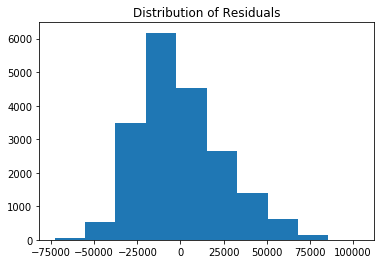

In [45]:
# Are residuals normally distributed?
plt.hist(work_mult['residual_age'])
plt.title('Distribution of Residuals')
plt.show()

Though it is ever so slightly skewed, the residuals are normal enough.

## Evenly distributed Residuals amoung Parameters

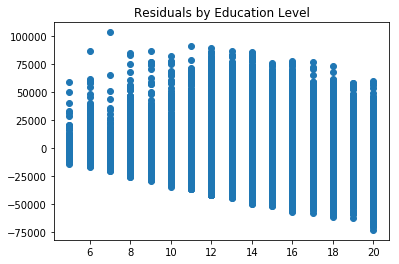

In [46]:
# Is variance constant for all values of the predictors?
plt.scatter(work_mult['EDUC'],work_mult['residual_age'])
plt.title('Residuals by Education Level')
plt.show()

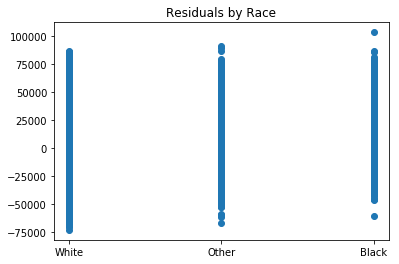

In [47]:
# Is variance constant for all values of the predictors?
plt.scatter(work_mult['Race'],work_mult['residual_age'])
plt.title('Residuals by Race')
plt.show()

This looks great too. There is a little inconsistency in the education level residuals, but overall both features seem pretty balanced.

## Homoscedastic Residuals

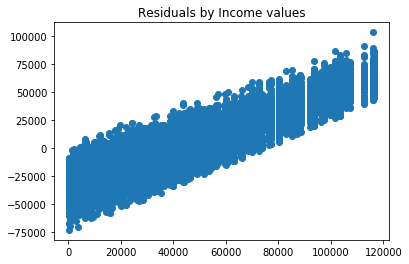

In [48]:
# Is variance constant for all values of the outcome?
plt.scatter(work_mult['Income'],work_mult['residual_age'])
plt.title('Residuals by Income values')
plt.show()

This doesn't look that good. Although the error distribution seems to have a similar total variance amoung Income values, the mean of those error values varies largely per data value, going from about -4000 to 6000. That big a gap is too big for the numbers I've been esitmating. I'll have to fix this.

I can do this be performing a non-linear transformation on the income variable. 

I will take the square root of the income variable. So my model's predictions will now be relative to the square root of the respondant's income. 

In [49]:
work_mult['Income'].describe()

count     19526.000000
mean      39404.385934
std       27410.631068
min         363.000000
25%       17063.750000
50%       33585.000000
75%       56836.000000
max      116270.000000
Name: Income, dtype: float64

# Running Square Root Income Model

In [50]:
work_mult['IncomeSqrt'] = np.sqrt(work_mult['Income'])

In [51]:
print('Running Square Root Income model')
arise_sqrt_model = smf.mixedlm("IncomeSqrt ~ Race + EDUC",data=work_mult,groups=work_mult['AGE'], re_formula="~EDUC")
arise_sqrt_result = arise_sqrt_model.fit(method='nm', maxiter=200, full_output=True)
print(arise_sqrt_result.summary())
print("done!")

Running Square Root Income model
           Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: IncomeSqrt  
No. Observations:   19526   Method:             REML        
No. Groups:         72      Scale:              4182.6001   
Min. group size:    39      Likelihood:         -109233.5371
Max. group size:    436     Converged:          Yes         
Mean group size:    271.2                                   
------------------------------------------------------------
                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept         37.905    3.288 11.528 0.000 31.460 44.349
Race[T.Other]     20.239    1.955 10.352 0.000 16.407 24.072
Race[T.White]     31.201    1.305 23.910 0.000 28.643 33.759
EDUC               8.665    0.268 32.284 0.000  8.139  9.191
Group Var        253.030    1.839                           
Group x EDUC Cov -15.266    0.139                           
EDU

In [52]:
# get model residuals
work_mult['residual_age_sqrt']=arise_sqrt_result.resid

## Normally Distributed Residuals

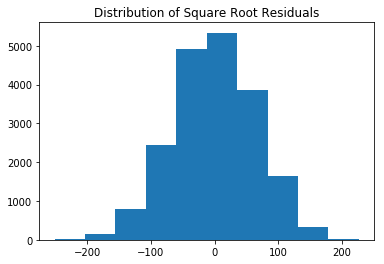

In [53]:
# Are residuals normally distributed?
plt.hist(work_mult['residual_age_sqrt'])
plt.title('Distribution of Square Root Residuals')
plt.show()

The residuals were somewhat skewed before, but now they look almost perfectly normal. It looks like the model has improved in more than the intended way, great!

## Evenly distributed Residuals amoung Parameters

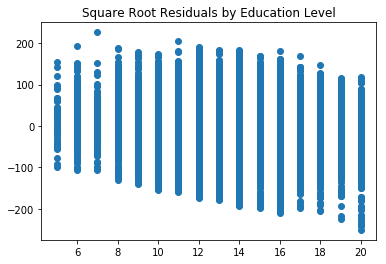

In [54]:
# Is variance constant for all values of the predictors?
plt.scatter(work_mult['EDUC'],work_mult['residual_age_sqrt'])
plt.title('Square Root Residuals by Education Level')
plt.show()

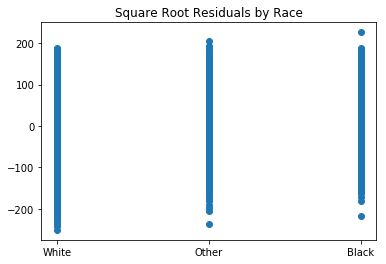

In [55]:
# Is variance constant for all values of the predictors?
plt.scatter(work_mult['Race'],work_mult['residual_age_sqrt'])
plt.title('Square Root Residuals by Race')
plt.show()

The residual's distribution about the parameters also looks even better, especially for education level.

## Homoscedastic Residuals

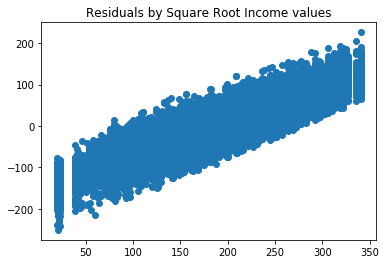

In [56]:
# Is variance constant for all values of the outcome?
plt.scatter(work_mult['IncomeSqrt'],work_mult['residual_age_sqrt'])
plt.title('Residuals by Square Root Income values')
plt.show()

The residuals are definitely also much improved. The gap between the residual for the highest and the lowest Income values is noq only about -160 and 110. That is very reasonable when predicting Income values which average to be about 30,000.

Still, it retains the same slanted slopt that it had before. And try as I might with other combination of linear transformations, I was not about to remove it. I may be able to fix the problem with Weighted Regression, where I apply a scaler to the Income variable based on it's residuals at that value. However, the output would become much harder to interperet for the kind of analysis I want to perform.

# Interpreting Model Results

In [57]:
print('Running Square Root Income model')
arise_sqrt_model = smf.mixedlm("IncomeSqrt ~ Race + EDUC",data=work_mult,groups=work_mult['AGE'], re_formula="~EDUC")
arise_sqrt_result = arise_sqrt_model.fit(method='nm', maxiter=200, full_output=True)
print(arise_sqrt_result.summary())
print("done!")

Running Square Root Income model
           Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: IncomeSqrt  
No. Observations:   19526   Method:             REML        
No. Groups:         72      Scale:              4182.6001   
Min. group size:    39      Likelihood:         -109233.5371
Max. group size:    436     Converged:          Yes         
Mean group size:    271.2                                   
------------------------------------------------------------
                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept         37.905    3.288 11.528 0.000 31.460 44.349
Race[T.Other]     20.239    1.955 10.352 0.000 16.407 24.072
Race[T.White]     31.201    1.305 23.910 0.000 28.643 33.759
EDUC               8.665    0.268 32.284 0.000  8.139  9.191
Group Var        253.030    1.839                           
Group x EDUC Cov -15.266    0.139                           
EDU

In [61]:
white = []
black = []
other = []
indx = []
for educ in range(5,21):
    indx.append('{} years of Education'.format(educ))
    for race in ['White','Black','Other']:
        if race == 'White':
            inc = (37.905 + 31.201 + 8.665*educ)**2
            white.append('${}'.format(round(inc,2)))
        if race == 'Black':
            inc = (37.905 + 8.665*educ)**2
            black.append('${}'.format(round(inc,2)))
        if race == 'Other':
            inc = (37.905 + 20.239 + 8.665*educ)**2
            other.append('${}'.format(round(inc,2)))     

In [62]:
results = pd.DataFrame(index=indx)
results["White"] = white
results["Black"] = black
results["Other"] = other

In [63]:
display(results)

,White,Black,Other
5 years of Education,$12640.73,$6598.31,$10295.96
6 years of Education,$14664.24,$8081.11,$12129.5
7 years of Education,$16837.92,$9714.07,$14113.2
8 years of Education,$19161.76,$11497.2,$16247.07
9 years of Education,$21635.76,$13430.49,$18531.1
10 years of Education,$24259.93,$15513.95,$20965.3
11 years of Education,$27034.27,$17747.57,$23549.66
12 years of Education,$29958.76,$20131.35,$26284.19
13 years of Education,$33033.43,$22665.3,$29168.88
14 years of Education,$36258.25,$25349.42,$32203.74


All the modeling varibles have extremely low p-values, so my results are very significant. Also keep in mind that because of the nature of linear regression and categorial variabled, the model interpreted being black as the base case. My fixed effect linear equation is: 

$sqrt(Income) = 39.809 + 8.442 * Education + 22.323 * ifother + 32.038 * ifwhite$

where 'ifother' is 1 if the person is not white or black, and zero otherwise, and 'ifwhite' is equal to 1 is the respondant is white and 0 otherwise. 

This means race gives has quite the effect. A white person with 5 years of education makes an average of \$12,640.73 a year, while the average black person with similar education and age makes only \$6,598.31 a year, the average non-white, non-black making \$10295.96 a year. It takes the average non-white, non-black person a little more than 1 year of education before they reach the average white starting point, and by then the average white person is making more than \$14664.24 a year. It takes the average black person another 4 additional years of education, 9 in total, to reach the same starting point as the average white person, and by then the average white person is making \$21635.76 a year. 

So, while the difference between races is extremely large, it can be offset by education. In fact, the difference between the average salary at 5 years of schoolings to 20 years of schooling is even larger.  For whites, the difference is \$13,009.00 versus \$57,930.23. For blacks, the difference is \$6,727.12 versus \$43,534.41. And for all other races, the difference is \$10,887.25 versus \$53348.06. These ranges are much larger than the gaps between races. In fact, the gaps between completing high school (12 years), college (16 years), and 4 postgraduate years (20 years) are each larger on their own than any gap between average incomes of different races of similar education levels.

So, which is more important when determining income? Education or Race? 

The answer is Education. Even though race is clearly proven by the data to be an important factor, the difference between education levels has multiple gaps larger than the biggest racial gap. The GSS Data shows that years spent is school is more important than race when determining income between American individuals of the same age. 

## References

http://gss.norc.org/